In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import PercentFormatter
import chardet
from scipy.stats import pearsonr

from seaborn import violinplot
from seaborn import boxplot
from seaborn import displot

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from boruta import BorutaPy

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from scipy.stats import ks_2samp

from sklearn.linear_model import LogisticRegression

import xgboost as xgb

# **Descrição do Projeto**
1. A base de dados foi retirada do seguinte desafio do kaggle https://www.kaggle.com/competitions/santander-customer-satisfaction/data
2. A base de dados está aleatorizada e contém uma série de colunas numéricas
3. A variável 'target' é a que deve ser prevista
3. 'TARGET' = 0 significa cliente satisfeito.
4. 'TARGET' = 1 significa cliente insatisfeito.

In [2]:
#determinar encoding do CSV
rawdata=open('/Users/Alvaro/Documents/Coderhouse/Projeto/data.csv', 'rb').read()
chardet.detect(rawdata)

{'encoding': 'ascii', 'confidence': 1.0, 'language': ''}

In [3]:
#Data Acquisition
df = pd.read_csv('/Users/Alvaro/Documents/Coderhouse/Projeto/data.csv',delimiter=',',encoding='ascii')
df

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76015,151829,2,48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60926.490000,0
76016,151830,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118634.520000,0
76017,151835,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74028.150000,0
76018,151836,2,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84278.160000,0


In [5]:
#EDA
df.info()
#Todas as 371 colunas são numéricas. Não há variáveis com formato de texto.
#df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [68]:
#EDA
nulos=df.isnull().sum().sum()
print(f'qtd de nulos: {nulos}')
duplicados = df.duplicated().sum()
print(f'qtd de duplicados: {duplicados}')
qualitativas = [column for column in df if df[column].dtype.name == 'object']
print(f'qtd de colunas qualitativas: {len(qualitativas)}')
um_valor = [column for column in df if df[column].nunique() < 2]
print(f'qtd de colunas com apenas um valor: {len(um_valor)}')
binárias = [column for column in df if df[column].nunique() == 2]
print(f'qtd de colunas binárias: {len(binárias)}')
nao_binarias = [column for column in df if df[column].nunique() > 2]
print(f'qtd de colunas não binárias: {len(nao_binarias)}')
#Não há nenhum nulo ou duplicado. Cofirmado que não temos nenhuma qualitativa.

qtd de nulos: 0
qtd de duplicados: 0
qtd de colunas qualitativas: 0
qtd de colunas com apenas um valor: 34
qtd de colunas binárias: 106
qtd de colunas não binárias: 231


In [188]:
#EDA
df['TARGET'].value_counts(normalize=True)

TARGET
0    0.960431
1    0.039569
Name: proportion, dtype: float64

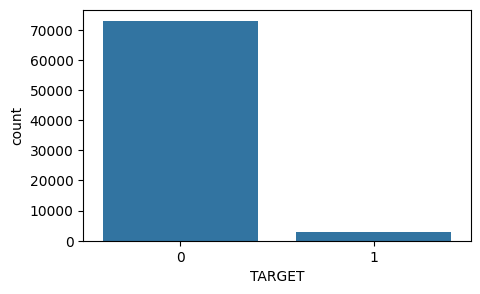

In [8]:
plt.figure(figsize=(5,3))
sns.countplot(x = 'TARGET', data = df)
plt.show()
#Target está bastante desbalanceada. Na hora que for dividir em treino e teste, lembrar de estratificar e utilizar oversampling.

In [ ]:
#Próxima etapa será pré processamento. Selecionar as principais features e separar em treino e teste.

In [58]:
X = df.drop(['TARGET'],axis=1)    #Independentes
y = df['TARGET'] # Target

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y,test_size = 0.3, random_state = 42)

In [40]:
rf = RandomForestClassifier(max_depth = 5, bootstrap = True)

In [41]:
np.int = np.int32
np.float = np.float64
np.bool = np.bool_
feat_selector = BorutaPy(rf, n_estimators = "auto", random_state = 999)

In [42]:
result_boruta = feat_selector.fit(X_train.values, y_train)

In [79]:
accept = X_train.columns[feat_selector.support_].to_list()
#feat_selector.ranking_ entega o ranking de cada uma das features

print(f"Qtd de features selecionadas: {len(accept)}")
print("Selecionadas:")
print(accept)

Qtd de features selecionadas: 37
Selecionadas:
['var15', 'imp_op_var40_efect_ult1', 'imp_op_var40_efect_ult3', 'imp_op_var41_efect_ult1', 'imp_op_var41_efect_ult3', 'imp_op_var41_ult1', 'imp_op_var39_efect_ult1', 'imp_op_var39_efect_ult3', 'imp_op_var39_ult1', 'ind_var5', 'ind_var8_0', 'ind_var30', 'num_var4', 'num_var5', 'num_var8_0', 'num_var30_0', 'num_var30', 'num_var35', 'num_var42', 'saldo_var5', 'saldo_var8', 'saldo_var30', 'saldo_var42', 'var36', 'num_var22_ult1', 'num_var22_ult3', 'num_med_var22_ult3', 'num_meses_var5_ult3', 'num_var45_hace2', 'num_var45_hace3', 'num_var45_ult1', 'num_var45_ult3', 'saldo_medio_var5_hace2', 'saldo_medio_var5_hace3', 'saldo_medio_var5_ult1', 'saldo_medio_var5_ult3', 'var38']


In [ ]:
#A partir desse momento, tem q escolhre um modelo e começar a modelar. Fazer uma cópia da base original e manter apenas essas 37 features

In [6]:
df_final = df[['var15','imp_op_var40_efect_ult1','imp_op_var40_efect_ult3','imp_op_var41_efect_ult1','imp_op_var41_efect_ult3','imp_op_var41_ult1',
'imp_op_var39_efect_ult1','imp_op_var39_efect_ult3','imp_op_var39_ult1','ind_var5','ind_var8_0','ind_var30','num_var4','num_var5',
'num_var8_0', 'num_var30_0', 'num_var30', 'num_var35', 'num_var42', 'saldo_var5', 'saldo_var8', 'saldo_var30', 'saldo_var42', 'var36',
'num_var22_ult1', 'num_var22_ult3', 'num_med_var22_ult3', 'num_meses_var5_ult3', 'num_var45_hace2', 'num_var45_hace3', 'num_var45_ult1',
'num_var45_ult3', 'saldo_medio_var5_hace2', 'saldo_medio_var5_hace3', 'saldo_medio_var5_ult1', 'saldo_medio_var5_ult3', 'var38', 'TARGET']]
df_final
#Essa será a base final utilizada no treinamento dos modelos

,var15,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,ind_var5,...,num_var45_hace2,num_var45_hace3,num_var45_ult1,num_var45_ult3,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,var38,TARGET
0,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0.00,0.00,0.00,0.00,39205.170000,0
1,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0.00,88.89,0.00,0.00,49278.030000,0
2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,...,0,0,0,0,3.00,0.18,3.00,2.07,67333.770000,0
3,37,0.0,0.0,0.0,0.0,195.0,0.0,0.0,195.0,1,...,27,3,18,48,186.09,0.00,91.56,138.84,64007.970000,0
4,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,3.00,0.30,40501.08,13501.47,117310.979016,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76015,48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,0,0,0,0.00,0.00,0.00,0.00,60926.490000,0
76016,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,36,3,9,48,130.65,0.00,0.00,0.00,118634.520000,0
76017,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,...,0,0,0,0,3.00,0.00,3.00,3.00,74028.150000,0
76018,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,...,0,0,0,0,3.00,1.74,3.00,2.58,84278.160000,0


In [51]:
X = df_final.drop(['TARGET'],axis=1)    #Independentes
y = df_final['TARGET'] # Target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y,test_size = 0.3, random_state = 42)

In [218]:
#PRimeiro modelo testado sera o Random Forest
dict_weights = {0:0.520599, 1: 12.6363}
rf = RandomForestClassifier(max_depth=4,random_state=42, class_weight=dict_weights).fit(X_train, y_train)

In [219]:
y_test_pred_RF = rf.predict(X_test) #Predict no teste
y_treino_pred_RF = rf.predict(X_train) #Predict no teste

[[17739  4165]
 [  281   621]]


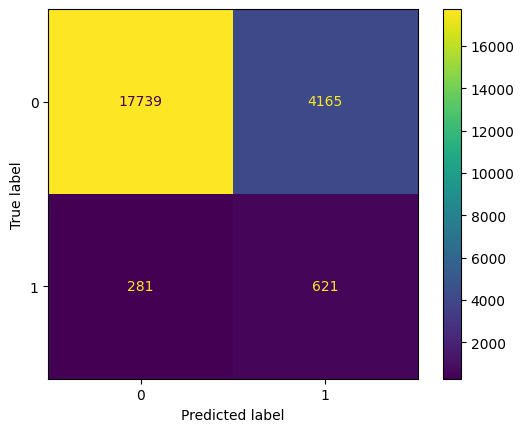

In [220]:
cm = confusion_matrix(y_test, y_test_pred_RF)
print(confusion_matrix(y_test, y_test_pred_RF))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [221]:
# Acurácia
acur = accuracy_score(y_test, y_test_pred_RF)
print(f"Accuracy of the classifier is: {acur}")
# Precisão!
prec = precision_score(y_test, y_test_pred_RF)
print(f"Precisão: {prec}")
#Recall!
rec = recall_score(y_test, y_test_pred_RF)
print(f"Recall: {rec}")
#F1_Score!
f1 = f1_score(y_test, y_test_pred_RF)
print(f"F1 Score: {f1}")
#KS
KS = ks_2samp(y_test_pred_RF[y_test_pred_RF == 0], y_test_pred_RF[y_test_pred_RF == 1])
print(f"KS: {round(KS[0],2)*100}")
#KS V2
def ks_v2 (y_true,y_pred_proba):
    pos_preds__pos=y_pred_proba[y_true==1]
    neg_preds__pos=y_pred_proba[y_true==0]
    return ks_2samp(pos_preds__pos,neg_preds__pos)[0]
ks_treino = ks_v2(y_train,y_treino_pred_RF)
ks_teste = ks_v2(y_test,y_test_pred_RF)
delta = ks_treino - ks_teste
print('ks_treino, {}\nks_teste {}\n,delta{}'.format(ks_treino,ks_teste,delta))

Accuracy of the classifier is: 0.8050513022888713
Precisão: 0.12975344755536983
Recall: 0.688470066518847
F1 Score: 0.21835443037974683
KS: 100.0
ks_treino, 0.5200145962061904
ks_teste 0.49832214833038824
,delta0.021692447875802157


In [224]:
#Testando a regressão logística
dict_weights = {0:0.520599, 1: 12.6363}
reg_logistica = LogisticRegression(random_state=42,class_weight=dict_weights,max_iter=3000).fit(X, y)

c:\Users\Alvaro\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [225]:
y_test_pred_RL = reg_logistica.predict(X_test)
y_treino_pred_RL = reg_logistica.predict(X_train)

[[12266  9638]
 [  190   712]]


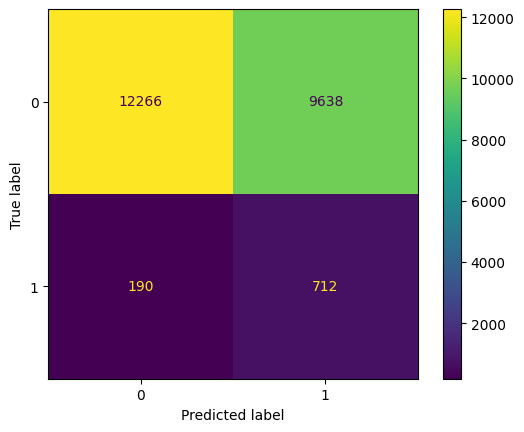

In [226]:
cm = confusion_matrix(y_test, y_test_pred_RL)
print(confusion_matrix(y_test, y_test_pred_RL))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [227]:
# Acurácia
acur = accuracy_score(y_test, y_test_pred_RL)
print(f"Accuracy of the classifier is: {acur}")
# Precisão!
prec = precision_score(y_test, y_test_pred_RL)
print(f"Precisão: {prec}")
#Recall!
rec = recall_score(y_test, y_test_pred_RL)
print(f"Recall: {rec}")
#F1_Score!
f1 = f1_score(y_test, y_test_pred_RL)
print(f"F1 Score: {f1}")
#KS
KS = ks_2samp(y_test_pred_RL[y_test_pred_RL == 0], y_test_pred_RL[y_test_pred_RL == 1])
print(f"KS: {round(KS[0],2)*100}")
#KS V2
def ks_v2 (y_true,y_pred_proba):
    pos_preds__pos=y_pred_proba[y_true==1]
    neg_preds__pos=y_pred_proba[y_true==0]
    return ks_2samp(pos_preds__pos,neg_preds__pos)[0]
ks_treino = ks_v2(y_train,y_treino_pred_RL)
ks_teste = ks_v2(y_test,y_test_pred_RL)
delta = ks_treino - ks_teste
print('ks_treino, {}\nks_teste {}\n,delta{}'.format(ks_treino,ks_teste,delta))

Accuracy of the classifier is: 0.569060773480663
Precisão: 0.06879227053140097
Recall: 0.7893569844789357
F1 Score: 0.1265552790615002
KS: 100.0
ks_treino, 0.3316619383966962
ks_teste 0.34934602757608696
,delta-0.01768408917939074


In [146]:
xgboost_clf = xgb.XGBClassifier(scale_pos_weight=24.28,eta=1,seed=42).fit(X, y)

In [147]:
y_test_pred_XG = xgboost_clf.predict(X_test)
y_treino_pred_XG = xgboost_clf.predict(X_train)

[[19599  2305]
 [   26   876]]


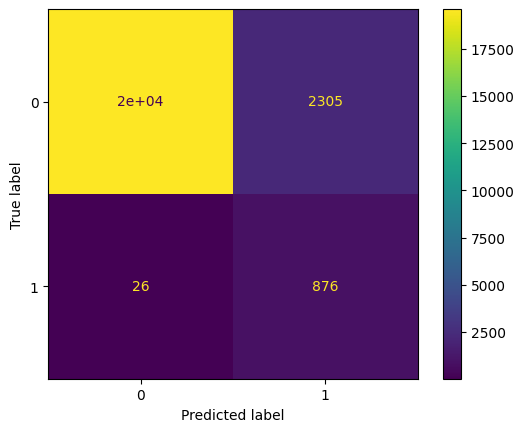

In [156]:
cm = confusion_matrix(y_test, y_test_pred_XG)
print(confusion_matrix(y_test, y_test_pred_XG))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [142]:
# Acurácia
acur = accuracy_score(y_test, y_test_pred_XG)
print(f"Accuracy of the classifier is: {acur}")
# Precisão!
prec = precision_score(y_test, y_test_pred_XG)
print(f"Precisão: {prec}")
#Recall!
rec = recall_score(y_test, y_test_pred_XG)
print(f"Recall: {rec}")
#F1_Score!
f1 = f1_score(y_test, y_test_pred_XG)
print(f"F1 Score: {f1}")
#KS
KS = ks_2samp(y_test_pred_XG[y_test_pred_XG == 0], y_test_pred_XG[y_test_pred_XG == 1])
print(f"KS: {round(KS[0],2)*100}")
#KS V2
def ks_v2 (y_true,y_pred_proba):
    pos_preds__pos=y_pred_proba[y_true==1]
    neg_preds__pos=y_pred_proba[y_true==0]
    return ks_2samp(pos_preds__pos,neg_preds__pos)[0]
ks_treino = ks_v2(y_train,y_treino_pred_XG)
ks_teste = ks_v2(y_test,y_test_pred_XG)
delta = ks_treino - ks_teste
print('ks_treino, {}\nks_teste {}\n,delta{}'.format(ks_treino,ks_teste,delta))

Accuracy of the classifier is: 0.8977900552486188
Precisão: 0.2753850990254637
Recall: 0.9711751662971175
F1 Score: 0.429096252755327
KS: 100.0
ks_treino, 0.8547006317218417
ks_teste 0.8659432451868181
,delta-0.011242613464976348


<Axes: >

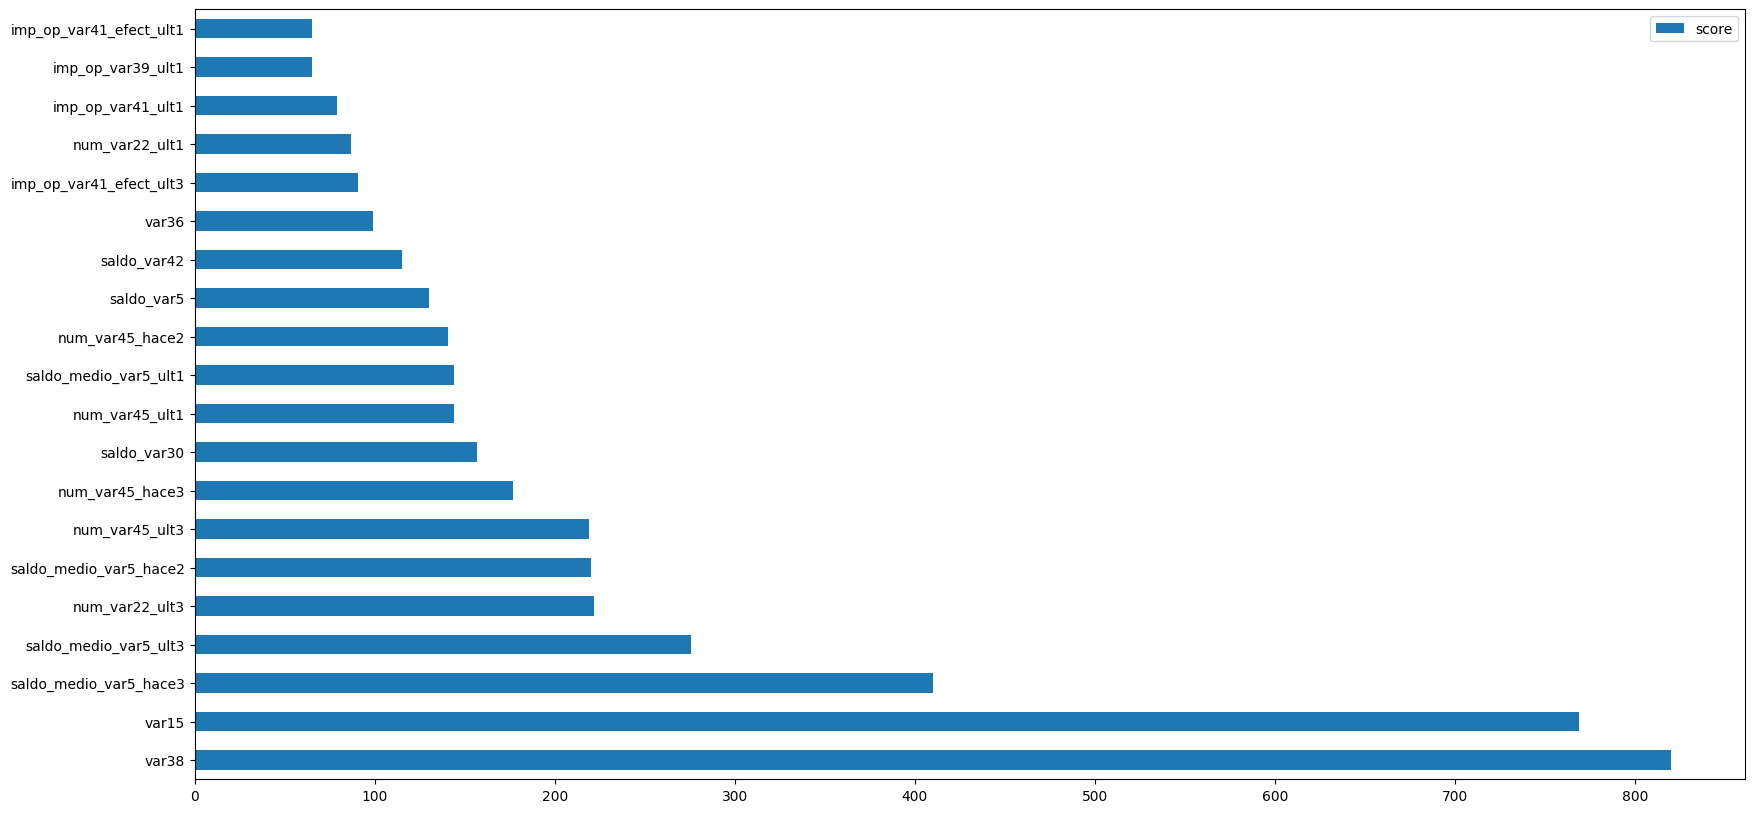

In [236]:
feature_important = xgboost_clf.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=True)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 20 features

Após rodar os 3 modelos, o que apresentou o melhor KS foi o XGBoost. Ele será o modelo escolhido